In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.graphics.tsaplots as tsa_plots
from pandas.plotting import lag_plot

import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

from math import sqrt
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
# from matplotlib.pyplot import rcParams
# rcParams['figure.figsize'] = 10, 5

### EDA and data visualization

In [2]:
data_cocacola = pd.read_excel('CocaCola_Sales_Rawdata.xlsx')
data_cocacola.head(10)

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996
5,Q2_87,2104.411995
6,Q3_87,2014.362999
7,Q4_87,1991.746998
8,Q1_88,1869.049999
9,Q2_88,2313.631996


In [3]:
data_cocacola.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Quarter  42 non-null     object 
 1   Sales    42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 800.0+ bytes


In [4]:
data_cocacola.columns

Index(['Quarter', 'Sales'], dtype='object')

In [5]:
Temp_Data = data_cocacola.Quarter.str.replace(r'(Q\d)_(\d+)', r'19\2-\1')
data_cocacola['quarter'] = pd.to_datetime(Temp_Data).dt.strftime('%b-%Y')
data_cocacola.head()

,Quarter,Sales,quarter
0,Q1_86,1734.827000,Jan-1986
1,Q2_86,2244.960999,Apr-1986
2,Q3_86,2533.804993,Jul-1986
3,Q4_86,2154.962997,Oct-1986
4,Q1_87,1547.818996,Jan-1987


In [6]:
data_cocacola.shape

(42, 3)

Text(0, 0.5, 'Sales')

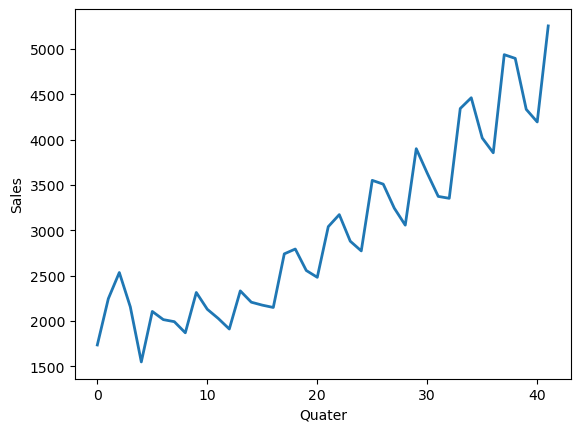

In [7]:
plt.plot(data_cocacola["Sales"],linewidth=2)
plt.xlabel("Quater")
plt.ylabel("Sales")

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

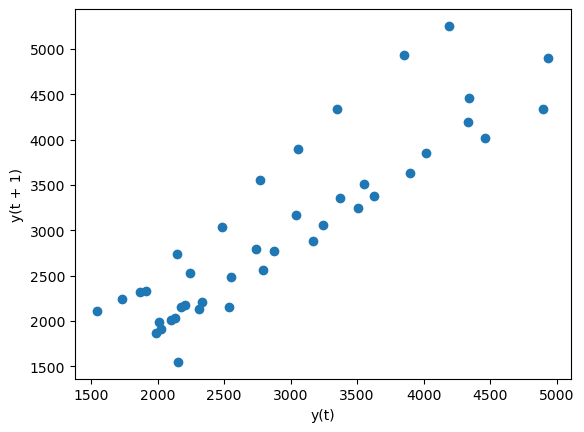

In [8]:
lag_plot(data_cocacola["Sales"])

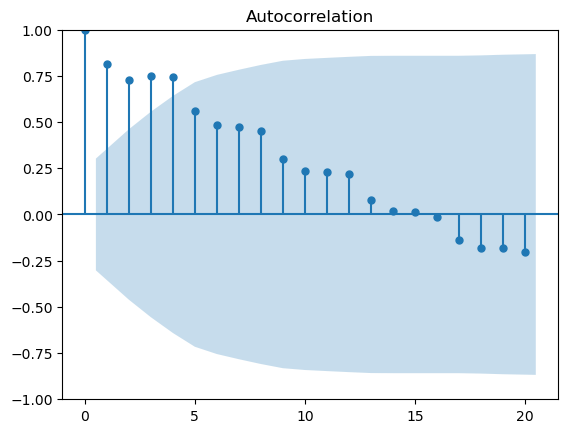

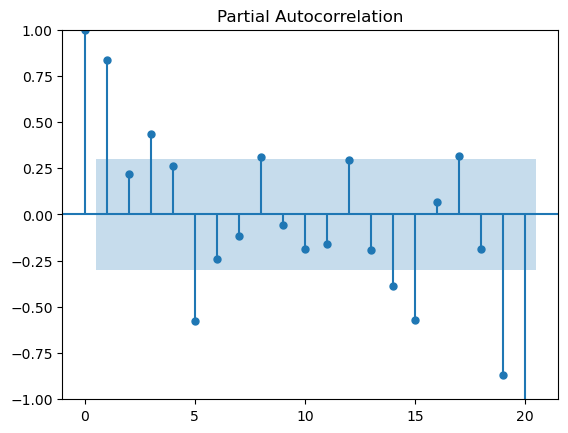

In [9]:
tsa_plots.plot_acf(data_cocacola["Sales"],lags=20)
tsa_plots.plot_pacf(data_cocacola["Sales"],lags=20);

### Train Test split

In [10]:
train = data_cocacola.head(35)
test = data_cocacola.tail(7)

In [11]:
test

,Quarter,Sales,quarter
35,Q4_94,4017.0,Oct-1994
36,Q1_95,3854.0,Jan-1995
37,Q2_95,4936.0,Apr-1995
38,Q3_95,4895.0,Jul-1995
39,Q4_95,4333.0,Oct-1995
40,Q1_96,4194.0,Jan-1996
41,Q2_96,5253.0,Apr-1996


### plotting moving average

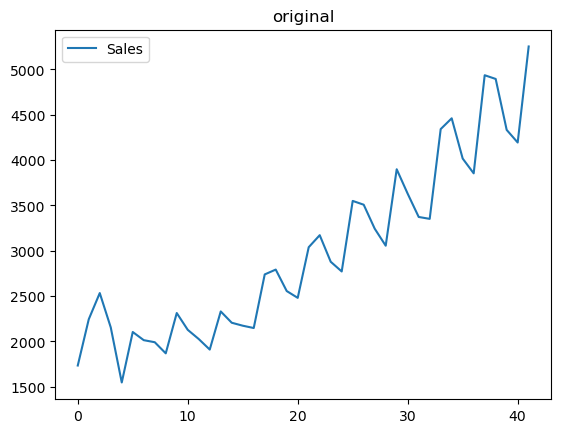

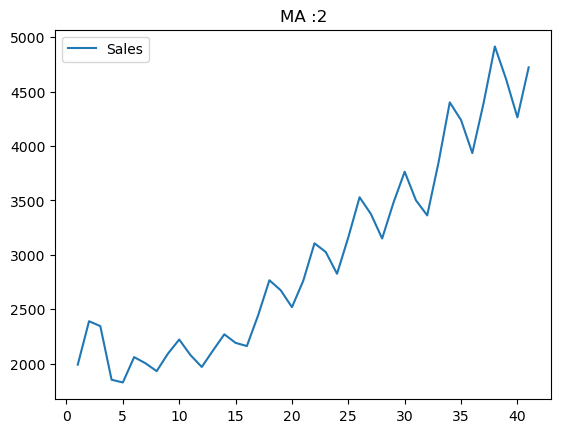

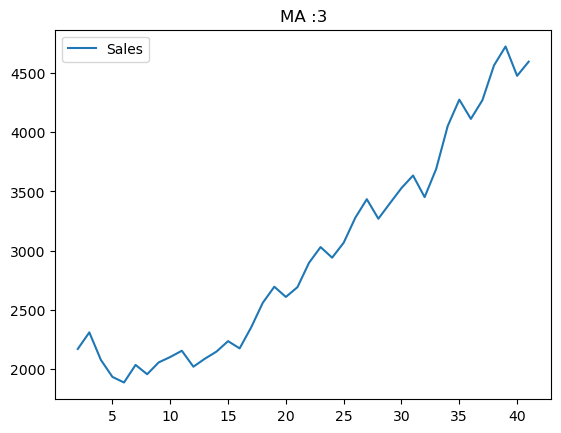

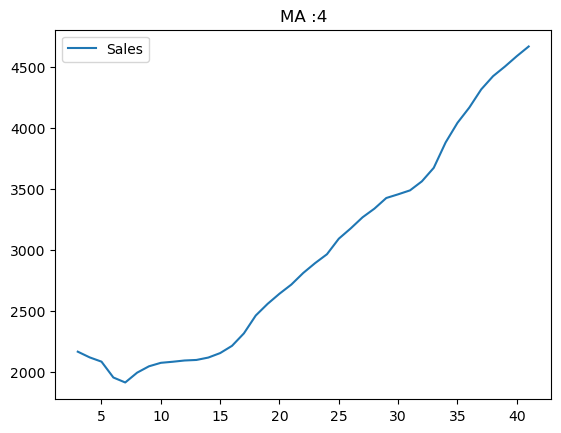

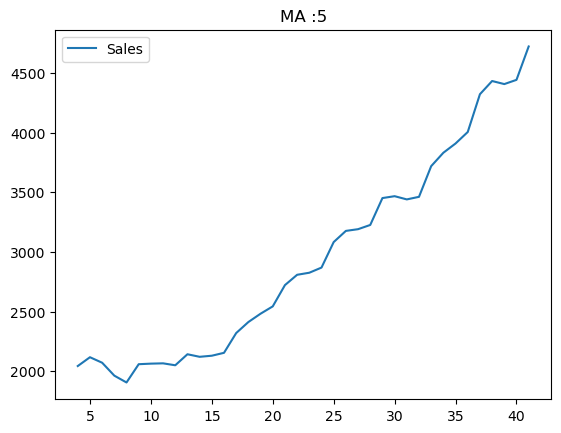

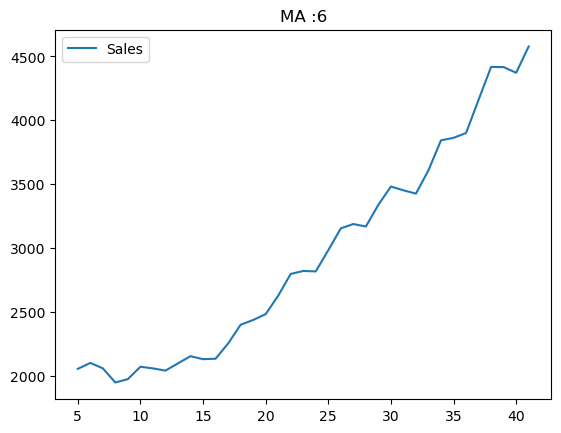

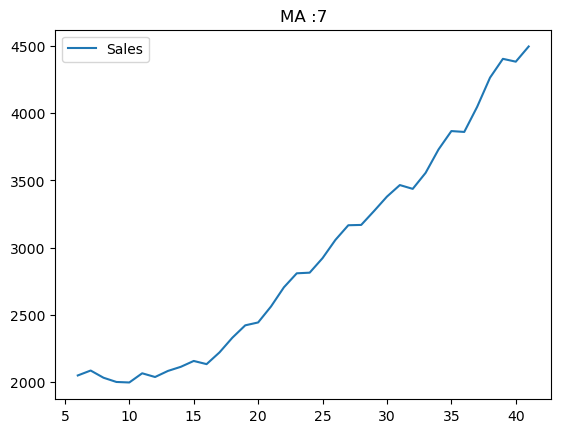

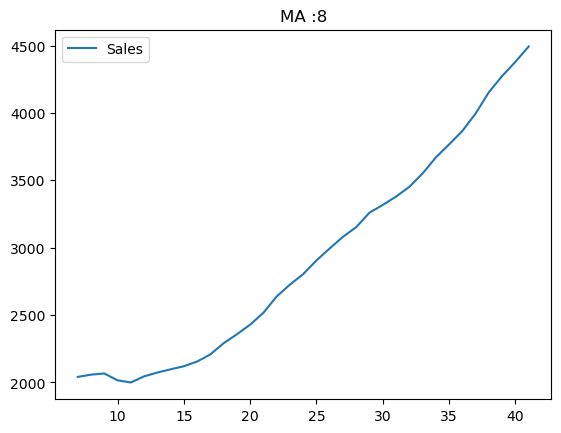

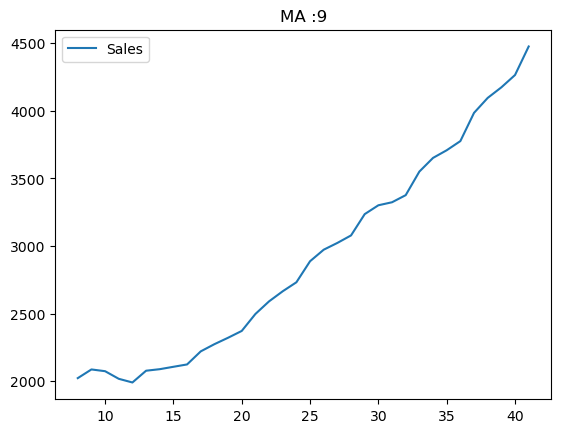

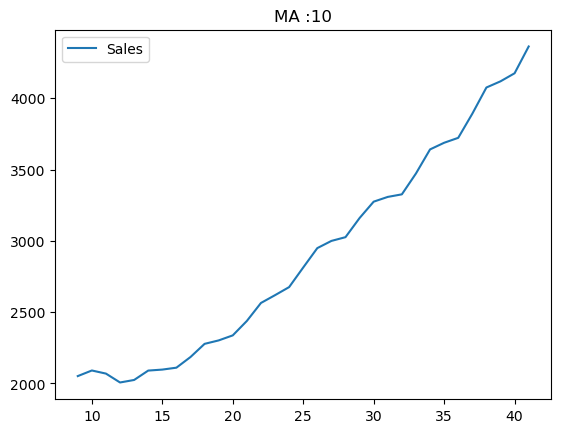

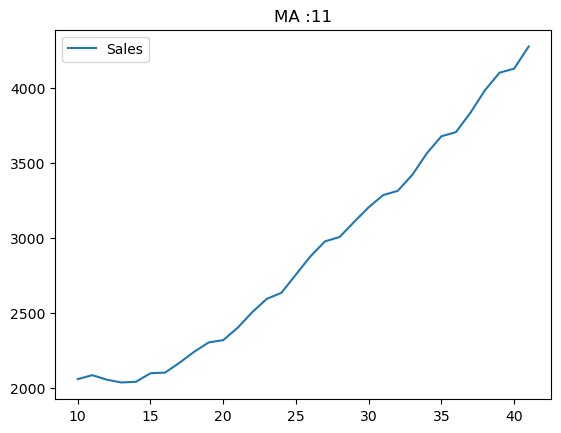

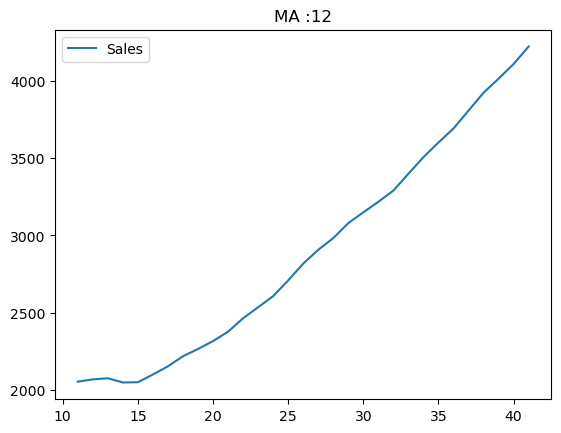

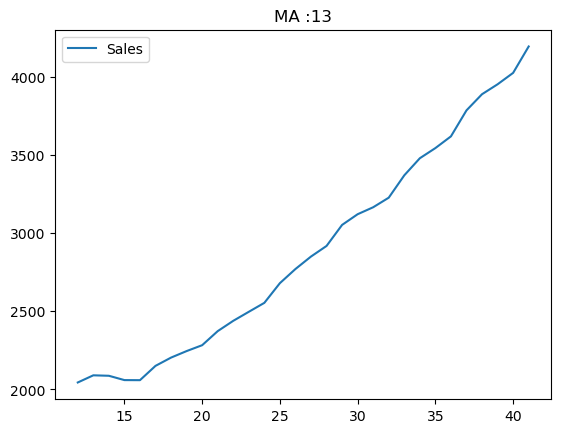

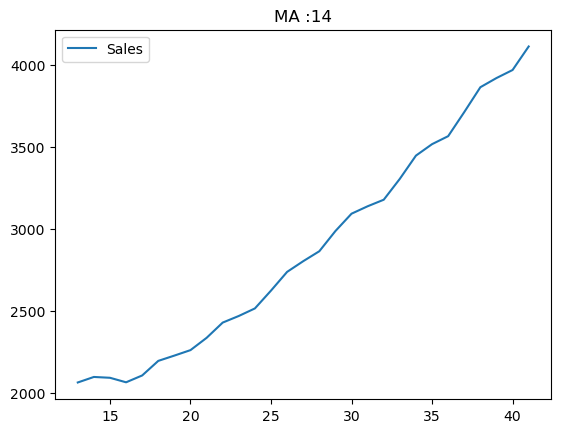

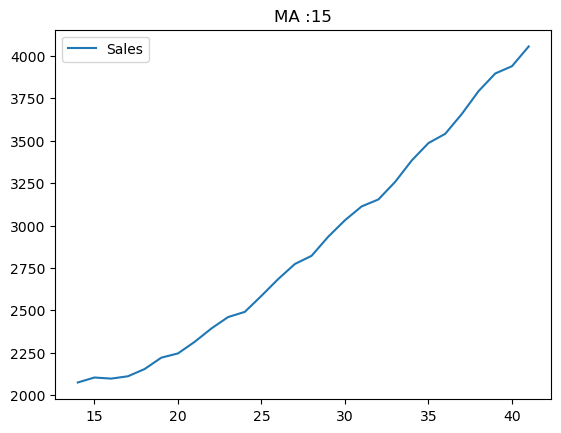

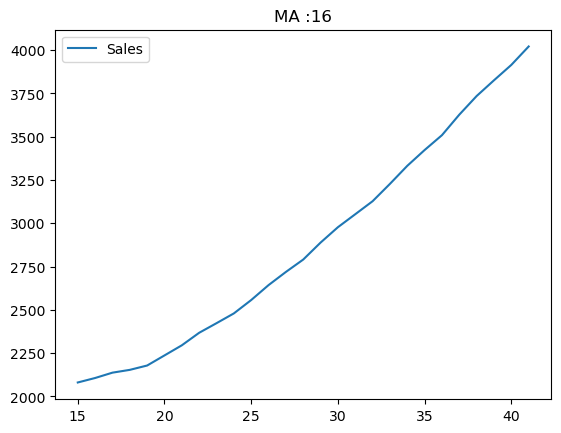

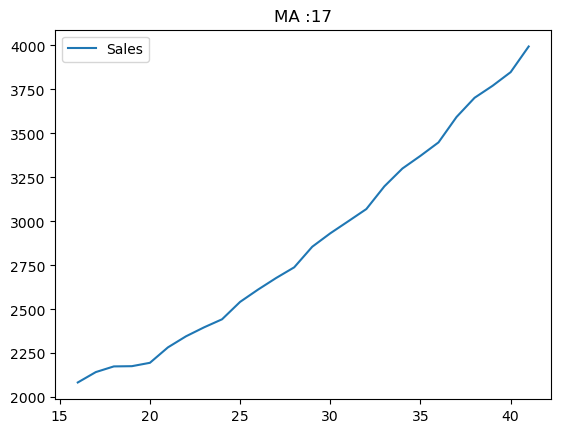

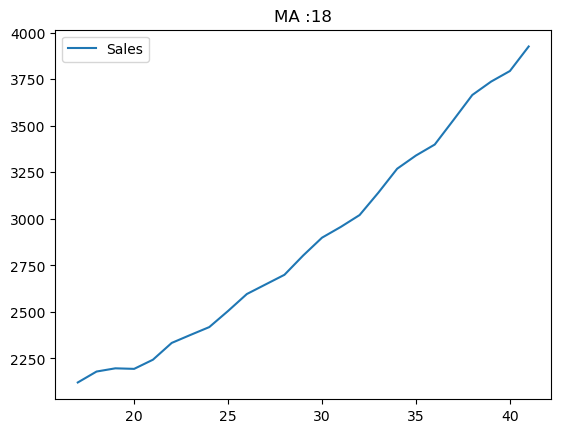

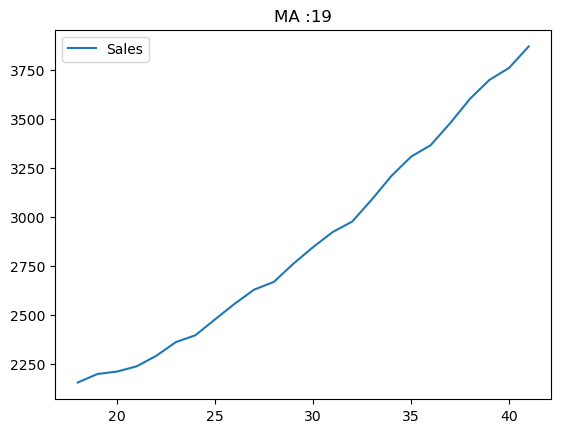

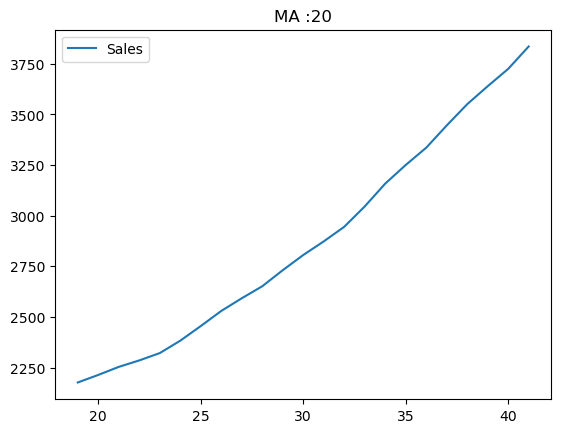

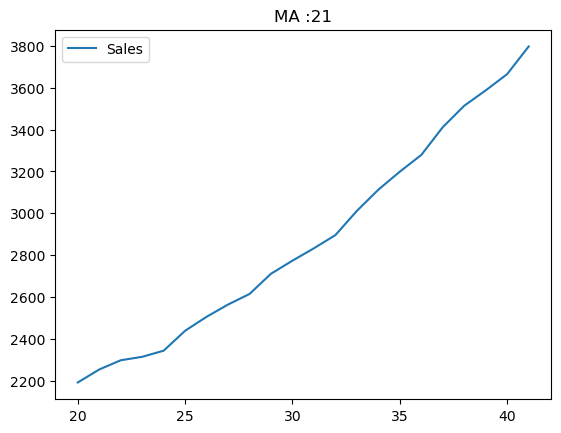

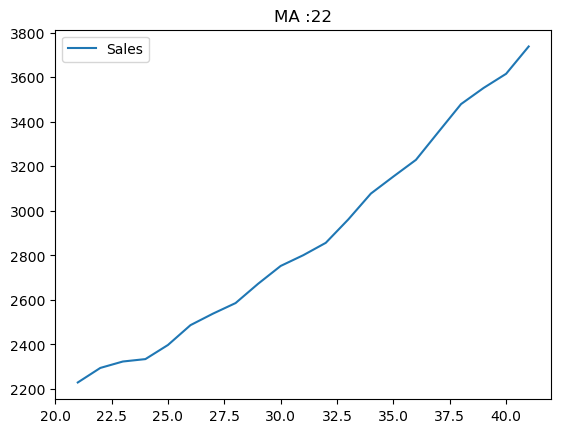

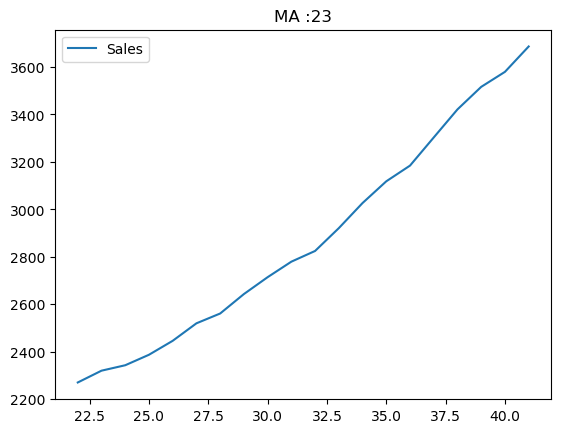

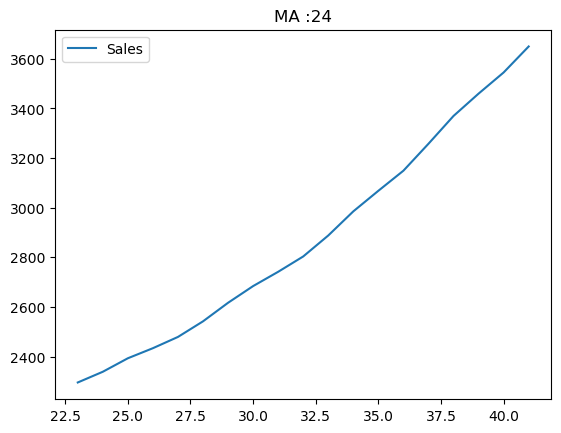

In [12]:
data_cocacola.plot()
plt.title("original")
plt.legend(loc = 'best')
plt.show()

for i in range(2, 25):
    data_cocacola.rolling(window = i).mean().plot(label = str(i))
    plt.title("MA :"+str(i))
    plt.legend(loc = 'best')
    plt.show()

### Time series decomposition 

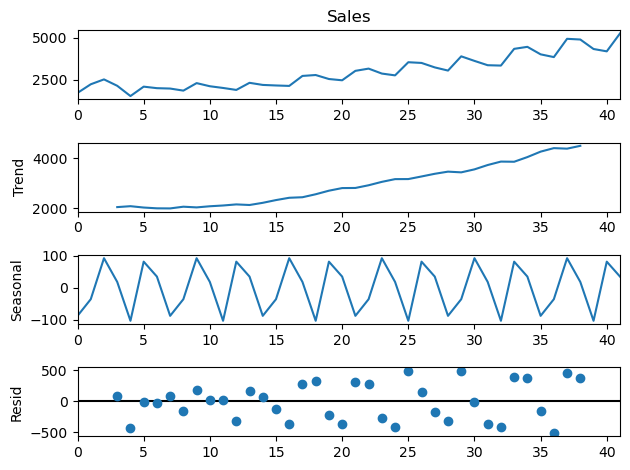

In [13]:
seasonal_decompose(data_cocacola["Sales"],period=7).plot();

### Evaluation metric RMSE

In [14]:
def RMSE(org,pred):
    rmse = np.sqrt(np.mean((np.array(org)-np.array(pred))**2))
    return rmse

In [15]:
RMSE(5,10)

5.0

### 1. Simple Exponential Method

In [16]:
simple_model=SimpleExpSmoothing(train["Sales"]).fit()
pred_sim=simple_model.predict(start=test.index[0],end=test.index[-1])
SEM=RMSE(test.Sales,pred_sim)
print("RMSE values for Simple Exponential :",RMSE(test.Sales,pred_sim))

RMSE values for Simple Exponential : 532.9747246731538


### 2. Holt method 

In [17]:
holt_model=Holt(train["Sales"]).fit()
pred_holt=holt_model.predict(start=test.index[0],end=test.index[-1])
HM=RMSE(test.Sales,pred_holt)
print("RMSE values for holt :",RMSE(test.Sales,pred_holt))

RMSE values for holt : 471.77866342632706


### 3 Holts winter exponential smoothing with additive seasonality and additive trend

In [18]:
holt_model_add_add = ExponentialSmoothing(train["Sales"],seasonal = "add",trend = "add",seasonal_periods = 4).fit()
pred_holt_add_add = holt_model_add_add.predict(start = test.index[0],end = test.index[-1])
HWEA=RMSE(test.Sales, pred_holt_add_add)
print('RMSE Value of Holts add and add :',RMSE(test.Sales, pred_holt_add_add))

RMSE Value of Holts add and add : 259.796962833617


### 4 Holts winter exponential smoothing with multiplicative seasonality and additive trend

In [19]:
holt_model_multi_add = ExponentialSmoothing(train["Sales"],seasonal = "mul",trend = "add",seasonal_periods = 4).fit()
pred_holt_multi_add = holt_model_multi_add.predict(start = test.index[0],end = test.index[-1])
HWEM=RMSE(test.Sales, pred_holt_multi_add)
print('RMSE Value of Holts multi and add :',RMSE(test.Sales, pred_holt_multi_add))

RMSE Value of Holts multi and add : 69.13321788101135


# Model based forecasting methods


In [20]:
data_Sales=data_cocacola.copy()
data_Sales.head()

,Quarter,Sales,quarter
0,Q1_86,1734.827000,Jan-1986
1,Q2_86,2244.960999,Apr-1986
2,Q3_86,2533.804993,Jul-1986
3,Q4_86,2154.962997,Oct-1986
4,Q1_87,1547.818996,Jan-1987


In [21]:
data_Sales["t"]=np.arange(1,43)
data_Sales["t_squared"]=data_Sales["t"]*data_Sales["t"]
data_Sales["log_Sales"]=np.log(data_Sales["Sales"])
data_Sales.head()

,Quarter,Sales,quarter,t,t_squared,log_Sales
0,Q1_86,1734.827000,Jan-1986,1,1,7.458663
1,Q2_86,2244.960999,Apr-1986,2,4,7.716443
2,Q3_86,2533.804993,Jul-1986,3,9,7.837477
3,Q4_86,2154.962997,Oct-1986,4,16,7.675529
4,Q1_87,1547.818996,Jan-1987,5,25,7.344602


In [22]:
train = data_Sales.head(35)
test = data_Sales.tail(7)

### Linear Model

In [23]:
linear_model = smf.ols('Sales~t',data = train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(test['t'])))

LM=RMSE(test['Sales'], pred_linear)
print('RMSE Value of Linear :',RMSE(test['Sales'], pred_linear))

RMSE Value of Linear : 636.5072930351143


## Exponential Model 


In [24]:
Exp_model = smf.ols('log_Sales~t',data = train).fit()
pred_Exp = pd.Series(Exp_model.predict(pd.DataFrame(test['t'])))

EM=RMSE(test['Sales'], np.exp(pred_Exp))
print('RMSE Value of Exponential :',RMSE(test['Sales'], np.exp(pred_Exp)))

RMSE Value of Exponential : 493.34864848421216


##  Quadratic Model 


In [25]:
Quad_model= smf.ols('Sales~t+t_squared',data = train).fit()
pred_Quad = pd.Series(Quad_model.predict(test[["t","t_squared"]]))

QM=RMSE(test['Sales'], pred_Quad)
print('RMSE Value of Quadratic :',RMSE(test['Sales'], pred_Quad))

RMSE Value of Quadratic : 511.811731941731


## ARIMA model

In [26]:
series = data_cocacola.copy()
series.head()

,Quarter,Sales,quarter
0,Q1_86,1734.827000,Jan-1986
1,Q2_86,2244.960999,Apr-1986
2,Q3_86,2533.804993,Jul-1986
3,Q4_86,2154.962997,Oct-1986
4,Q1_87,1547.818996,Jan-1987


### Creating a validation dataset 

In [27]:
split_point = len(series) - 12
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', header = False)
validation.to_csv('validation.csv', header = False)

Dataset 30, Validation 12


### Creating a base model for evaluation

In [28]:
Arima_data=pd.read_excel("CocaCola_Sales_Rawdata.xlsx")
Arima_data=Arima_data["Sales"]
Arima_data.head()

0    1734.827000
1    2244.960999
2    2533.804993
3    2154.962997
4    1547.818996
Name: Sales, dtype: float64

In [29]:
X = Arima_data.values
X = X.astype('float32')
train_size = int(len(X) * 0.715)
train, test = X[0:train_size], X[train_size:]

In [30]:
print(train.shape)
print(test.shape)

(30,)
(12,)


### Walk Farward Validation

In [31]:
history = [x for x in train]
predictions = list()

In [32]:
for i in range(len(test)):
    yhat = history[-1]
    predictions.append(yhat)

    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))

>Predicted=3899.000, Expected=3629.000
>Predicted=3629.000, Expected=3373.000
>Predicted=3373.000, Expected=3352.000
>Predicted=3352.000, Expected=4342.000
>Predicted=4342.000, Expected=4461.000
>Predicted=4461.000, Expected=4017.000
>Predicted=4017.000, Expected=3854.000
>Predicted=3854.000, Expected=4936.000
>Predicted=4936.000, Expected=4895.000
>Predicted=4895.000, Expected=4333.000
>Predicted=4333.000, Expected=4194.000
>Predicted=4194.000, Expected=5253.000


In [33]:
RMSE(test,predictions)

576.33136

In [34]:
rmse_Persistence_model = 576.331

## Evaluation


In [35]:
list = [['Simple Exponential Method',SEM], ['Holt method',HM],
          ['Holt exp smoothing add',HWEA],['Holt exp smoothing multi',HWEM],
          ['Linear Model',LM],['Exponential model',EM],['Quadratic model',QM],
          ['Persistence/ Base model', rmse_Persistence_model]]

In [36]:
df = pd.DataFrame(list, columns = ['Model', 'RMSE_Value']) 
df

,Model,RMSE_Value
0,Simple Exponential Method,532.974725
1,Holt method,471.778663
2,Holt exp smoothing add,259.796963
3,Holt exp smoothing multi,69.133218
4,Linear Model,636.507293
5,Exponential model,493.348648
6,Quadratic model,511.811732
7,Persistence/ Base model,576.331000


#### Linear model has the highest value of RMSE and hence is chosen for deployment.